In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


In [2]:
def my_fft(data, sample_rate=10):
    fftSize = len(data)
    spectrum = np.fft.fft(data)
    freq = np.fft.fftfreq(fftSize, 1/sample_rate)
    return (freq, spectrum)

def my_ifft(spectrum):
    return np.fft.ifft(spectrum)

def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

/home/vtsianti/2409/Tutorial/miniforge/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/vtsianti/2409/Tutorial/miniforge/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


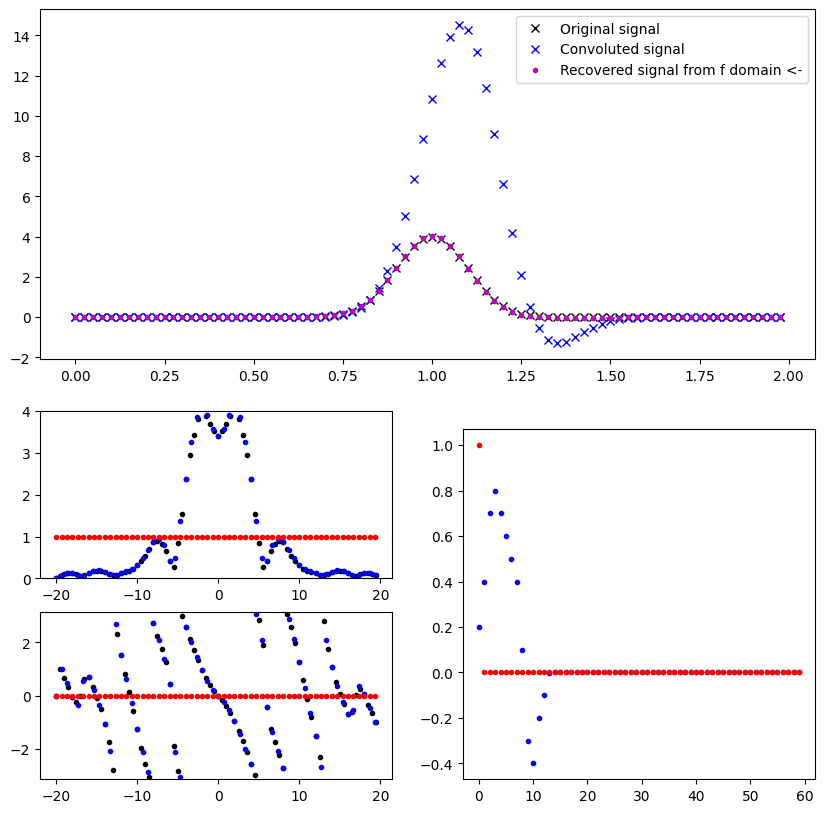

In [3]:
sampling_rate_Hz = 40
sample_time_s = 2

# generate time axis - for convenience
time_axis_s = np.arange(0, sample_time_s, 1/sampling_rate_Hz)

# make a simple impulse - note, the number of "zeros" are important to better charachterise in f domain the impulse response!
# -> see zero padding....
# exagerated -> use the same length as the signal under analysis
impulse_simple = np.zeros(len(time_axis_s))
# a bit more reasonable: just a few additional zeros...
impulse_simple = np.zeros(60)
impulse_simple[0] = 1

# let's define an impulse response
impulse_response = np.array([0.2, 0.4, 0.7, 0.8, 0.7, 0.6, 0.5, 0.4,0.1,-0.3, -0.4, -0.2, -0.1, -0.001, 0])
# zero padding
impulse_response = np.concatenate((impulse_response, np.zeros(len(impulse_simple)-len(impulse_response))))


########################
# generate a delta signal - original signal
original_signal = np.zeros(time_axis_s.shape)
original_signal[int(len(original_signal)/2)] = 1
# generate some more complex signal instead...
original_signal[(int(len(original_signal)/2)-10):(int(len(original_signal)/2)+10)] = np.ones(20) #np.random.randn(10)
original_signal[(int(len(original_signal)/2)-10):(int(len(original_signal)/2)+10)] = np.random.randn(20)
# generate a Gaussian instead
original_signal = gaussian(time_axis_s, sample_time_s/2, sample_time_s/20)

########################

##########
# generate convoluted signal - what I actually read from my system
convoluted_signal = np.convolve(original_signal, impulse_response)[0:len(time_axis_s)]
##########


### 1st processing
# if one knows the impulse response, one can also deconvolve the signal...
deconvoluted_signal, _ = signal.deconvolve(convoluted_signal, impulse_response)
# add zeros at the end... for consistency
deconvoluted_signal = np.concatenate((deconvoluted_signal, np.zeros(len(impulse_response) - 1)))

# make FFT of convoluted signal
(freq, spectrum_raw) = my_fft(original_signal, sample_rate=sampling_rate_Hz)
(freq, spectrum_convoluted) = my_fft(convoluted_signal, sample_rate=sampling_rate_Hz)
(freq_short, spectrum_response) = my_fft(impulse_response, sample_rate=sampling_rate_Hz)
(freq_short, spectrum_impulse) = my_fft(impulse_simple, sample_rate=sampling_rate_Hz)

#####
# take spectrum of raw signal, multiply it to spectrum of impulse response, go back to real domain
# 1) might need to interpolate spectrum_response, as this is typically much shorter signal...
idx_ = np.argsort(freq_short)
spectrum_response_interp = np.interp(freq, freq_short[idx_], spectrum_response[idx_])
# 2) simply multiply it to the spectrum of original signal, then apply inverse FFT
signal_frequency_processed = my_ifft(spectrum_raw*spectrum_response_interp)
# 3) one can actually get the original signal from the convoluted signal one reads!!!
#    THIS IS THE MOST INTERESTING !
signal_frequency_recovered = my_ifft(spectrum_convoluted/spectrum_response_interp)
#########

# plot it
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(time_axis_s, original_signal, 'kx', label='Original signal')
plt.plot(time_axis_s, convoluted_signal, 'bx', label='Convoluted signal')
#plt.plot(time_axis_s, deconvoluted_signal, 'g.', label='De-Convoluted signal')
#plt.plot(time_axis_s, signal_frequency_processed, 'r.', label='Processed signal in f domain ->')
plt.plot(time_axis_s, signal_frequency_recovered, 'm.', label='Recovered signal from f domain <-')
plt.legend()

plt.subplot(4,2,5)
plt.plot(freq, np.abs(spectrum_response_interp), 'k.')
plt.plot(freq_short, np.abs(spectrum_response), 'b.')
plt.plot(freq_short, np.abs(spectrum_impulse), 'r.')
plt.ylim([0, 4])
plt.subplot(4,2,7)
plt.plot(freq, np.angle(spectrum_response_interp), 'k.')
plt.plot(freq_short, np.angle(spectrum_response), 'b.')
plt.plot(freq_short, np.angle(spectrum_impulse), 'r.')
plt.ylim([-np.pi, np.pi])
plt.subplot(2,2,4)
plt.plot(impulse_response, 'b.')
plt.plot(impulse_simple, 'r.')